In [2]:
import numpy as np
import pandas as pd
from typing import List, Tuple, Union, Callable, Type
import warnings
from __future__ import annotations
from abc import ABC
from matplotlib import pyplot as plt
from tqdm import tqdm
import time
#suppress warnings
warnings.filterwarnings('ignore')

In [3]:
def confusion_matrix(y_hat: np.array, y: np.array) -> np.array:
    num_class = len(np.unique(y))
    matrix = np.zeros((num_class, num_class))
    for y_true, y_hat in zip(y, y_hat):
        matrix[y_hat][y_true] += 1
    return matrix
    

def recall(y_hat: np.array, y: np.array) -> np.array:
    matrix = confusion_matrix(y_hat, y)
    n = len(matrix)
    recall = np.zeros(n)
    for i in range(n):
        recall[i] = matrix[i][i]/np.sum(matrix[:, i])
    return recall

def precision(y_hat: np.array, y: np.array) -> np.array:
    matrix = confusion_matrix(y_hat, y)
    n = len(matrix)
    precision = np.zeros(n)
    for i in range(n):
        precision[i] = matrix[i][i]/np.sum(matrix[i, :])
    return precision
    
def f_score(y_hat: np.array, y: np.array, to_class: boolen = True) -> np.array:
    y_hat_class = y_hat
    y_class = y
    if to_class:
        y_hat_class = proba_to_class(y_hat)
        y_class = proba_to_class(y)
    r = recall(y_hat_class, y_class)
    p = precision(y_hat_class, y_class)
    f_score = 2*p*r/(p + r)
    return f_score

def one_hot_encoding(y: np.array) -> np.array:
    n = len(np.unique(y))
    m = len(y)
    zeros = np.zeros((m, n))
    for zero, i in zip(zeros, y):
        zero[i] = 1
    return zeros.transpose()

def proba_to_class(y_hat: np.array) -> np.array:
    classes = np.argmax(y_hat, axis = 0)
    return classes

In [4]:
def sigmoid(x: Union[int, np.array]) -> Union[int, np.array]:
    return np.exp(x)/(1 + np.exp(x))
        
def linear(x: Union[int, np.array]) -> Union[int, np.array]:
    return x

def softmax(x: Union[int, np.array]) -> Union[int, np.array]:
    return np.divide(np.exp(x), np.sum(np.exp(x), axis = 0))

def relu(x: Union[int, np.array]) -> Union[int, np.array]:
    return np.amax([x, np.zeros(x.shape)], axis= 0, initial=0)

def tanh(x: Union[int, np.array]) -> Union[int, np.array]:
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))

def mse(y_hat: np.array, y: np.array) -> np.array:
        return np.mean(np.square(y-y_hat))

In [4]:
class Loss(ABC):
    
    def __init__(self) -> None:
        pass
    
    def loss(self, y_hat: np.array, y: np.array) -> np.array:
        pass

class MSE(Loss):
    
    def __init__(self) -> None:
        super().__init__()
        
    def loss(self, y_hat: np.array, y: np.array) -> np.array:
        return np.mean(np.square(y-y_hat))
    
class Cross_entropy(Loss):
    
    def __init__(self) -> None:
        super().__init__()
        
    def loss(self, y_hat: np.array, y: np.array) -> np.array:
        epsilon = 1e-9
        return -np.mean(np.multiply(y, np.log(y_hat + epsilon)), axis = 1)
    

In [50]:
def dsigmoid(x: Union[int, np.array]) -> Union[int, np.array]:
    return sigmoid(x)*sigmoid(-x)

def dlinear(x: Union[int, np.array]) -> Union[int, np.array]:
    return np.ones(x.shape)

def drelu(x: Union[int, np.array]) -> Union[int, np.array]:
    return np.greater(x, 0).astype('int')

def dtanh(x: Union[int, np.array]) -> Union[int, np.array]:
    return 1 - np.square(tanh(x))

In [6]:
class Optimizer(ABC):
    
    def __init__(self, **kwargs: float) -> None:
        pass
        
    def fit_optimizer(self, w_opt: np.array,
                      b_opt: np.array, error_w: np.array,
                      error_b: np.array) -> Tuple[np.array]:
        pass

class Momentum(Optimizer):
    
    def __init__(self, lambd = 0.9) -> None:
        self.lambd = lambd
        
    def fit_optimizer(self, opt_w: np.array, 
                      opt_b: np.array, error_w: np.array,
                      error_b: np.array) -> Tuple[np.array]:
        opt_w = error_w + self.lambd * opt_w
        opt_b = error_b + self.lambd * opt_b
        
        update_w = opt_w
        update_b = opt_b
        
        return (opt_w, opt_b, update_w, update_b)
    

class RMSProp(Optimizer):
    
    def __init__(self, beta = 0.9) -> None:
        self.beta = beta
        
    def fit_optimizer(self, opt_w: np.array, 
                      opt_b: np.array, error_w: np.array,
                      error_b: np.array) -> Tuple[np.array]:
        opt_w = self.beta*opt_w + (1 - self.beta) * np.square(error_w)
        opt_b = self.beta*opt_b + (1 - self.beta) * np.square(error_b)
        
        update_w = np.divide(error_w, np.sqrt(opt_w))
        update_b = np.divide(error_b, np.sqrt(opt_b))
        
        return (opt_w, opt_b, update_w, update_b)
    

In [81]:
class Model(ABC):
    
    def __init__(self):
        self.weights = []
        self.biases = []
        self.best_weights = []
        self.best_biases = []
        self.best_loss = None
        self.activation_functions = []
        self.n = None
        self.optimizer = None
        self.loss = None
        self.metric = None
        self.num_layers = None
        self.metrics = {}
    
    def Input(self, shape: Tuple = (None, None)) -> int:
        pass
    
    def Output(self, shape: Tuple = (None, None)) -> int:
        pass
    
    def fit(self, X: np.array, y: np.array) -> Model:
        return self
    
    def add(self, nodes: int, activation_function: Callable[[Union[int, np.array]], Union[int, np.array]],
            weight: np.array) -> None:
        pass
    
    def complie(self, optimzer: Type[Optimizer]) -> None:
        pass
    
    def predict(self, x: np.array) -> np.array:
        pass
    
    def initialize(self) -> None:
        pass

In [417]:
class MLP(Model):
    
    def __init__(self) -> None:
        super().__init__()
        
    def Input(self, shape: Tuple = (None, None)) -> int:
        self.n = shape[1]
        
    def Output(self, shape: Tuple = (None, None)) -> int:
        pass
    
    def fit(self, X: np.array, y: np.array, eta: float, batch_size: int = 1,
            epochs: int = 1, verbose: int = 1, verbose_step: int = 10) -> MLP:
        
        opt_b = [np.zeros(bias.shape) for bias in self.biases]
        opt_w = [np.zeros(weight.shape) for weight in self.weights]
        
        y_hat = self.predict(X) 
        self.best_loss = np.mean(self.loss().loss(y_hat, y))
        
        for epoch in range(epochs):
            dim = min(sorted(y.shape, reverse = True)[1:] or [1])
            concat = np.concatenate([X.transpose(), y.transpose().reshape(-1, dim)], axis = 1)
            np.random.shuffle(concat)
            X_shuffle = concat[:, :X.shape[0]].transpose()
            y_shuffle = concat[:, X.shape[0]:].transpose()
            
            batches_X = [np.array(X_shuffle[:, i: i + batch_size]) for i in range(0, len(X[0]), batch_size)]
            batches_y = [y_shuffle[:, i: i + batch_size] for i in range(0, len(y), batch_size)]
            for batch_X, batch_y in zip(batches_X, batches_y):
                
                n = len(batch_X[0])
                error_b, error_w = self.backprop(batch_X, batch_y)                    
                
                for i in range(len(self.weights)):
                    
                    if self.optimizer is not None:
                        opt_w[i], opt_b[i], update_w, update_b = self.optimizer.fit_optimizer(
                            opt_w[i], opt_b[i], error_w[i], error_b[i])
                        
                    else:
                        update_w = error_w[i]
                        update_b = error_b[i]
                    
                    self.weights[i] -= eta*update_w/n
                    self.biases[i] -= eta*update_b/n
                    w = 'w' + str(i)
                    b = 'b' + str(i)
                    if w not in self.metrics and b not in self.metrics:
                        self.metrics[w] = [np.linalg.norm(self.weights[i])]
                        self.metrics[b] = [np.linalg.norm(self.biases[i])]
                    else:
                        self.metrics[w].append(np.linalg.norm(self.weights[i]))
                        self.metrics[b].append(np.linalg.norm(self.biases[i]))
                
            y_hat = self.predict(X)
            loss_hat = np.mean(self.loss().loss(y_hat, y))
            if verbose == 1 and epoch % int(max(1, epochs//verbose_step)) == 0:
                metric_score = self.metric(y_hat, y)
                print(f'{type(self.loss()).__name__}: {loss_hat}  ----- {self.metric.__name__}: {np.mean(metric_score)}')
            if loss_hat < self.best_loss:
                self.best_loss = loss_hat
                self.best_weights = self.weights
                self.best_biases = self.biases
                        
                        
                
    def backprop(self, X: np.array, y: np.array) -> List[np.array]:
        error_b = [np.zeros(bias.shape) for bias in self.biases]
        error_w = [np.zeros(weight.shape) for weight in self.weights]
        
        activation = X
        activations = [X]
        zs = []
        
        for weight, fun, bias in zip(self.weights, self.activation_functions, self.biases):
            z = np.dot(weight, activation) + bias.reshape(-1,1)
            zs.append(z)
            activation = fun(z)
            activations.append(activation)
        
        
        error = activations[-1] - y
        
        error_b[-1] = np.dot(error, np.ones(error.shape[1]).transpose())
        error_w[-1] = np.dot(error, activations[-2].transpose())
        
        for l in range(2, self.num_layers):
            z = zs[-l]
            dname = 'd' + self.activation_functions[-l].__name__
            dz = globals()[dname](z) 
            error = np.multiply(np.dot(self.weights[-l+1].transpose(), error), dz)
            error_b[-l] = np.dot(error, np.ones(error.shape[1]).transpose())
            error_w[-l] = np.dot(error, activations[-l-1].transpose())
            
        return error_b, error_w
            
    def add(self, nodes: int, activation_function: Callable[[Union[int, np.array]], Union[int, np.array]],
            weight: np.array = None, bias: np.array = None) -> None:
        
        if weight is None and bias is None:
            weight, bias  = self.initialize1(nodes, activation_function.__name__)
            
        n_w, m_w = weight.shape
        
        weight = weight.transpose()
        
        self.weights.append(weight)
        self.biases.append(bias)
        self.best_weights.append(weight)
        self.best_biases.append(bias)
        self.activation_functions.append(activation_function)
        self.n = nodes
        
    def complie(self, loss: Type[Loss] = None, optimizer: Type[Optimizer] = None, metric = None) -> None:
        self.num_layers = len(self.weights) + 1
        self.optimizer = optimizer
        self.loss = loss
        self.metric = metric
        
    
    def predict(self, x: np.array) -> np.array:
        for weight, fun, bias in zip(self.best_weights, self.activation_functions, self.best_biases):
            x = fun(np.dot(weight, x) + bias.reshape(-1,1))
        return x     
    
    
    def initialize(self, m: int) -> None:
        weight = np.random.uniform(-0.5, 0.5, size = (self.n, m))
        bias = np.random.uniform(-0.5, 0.5, size = (m))
        return weight, bias
    
    def initialize1(self, m: int, activation_function: str) -> None:
        if activation_function in ['sigmoid', 'tanh', 'softmax', 'linear']:
            limit = np.sqrt(6/(self.n + m))
            weight = np.random.uniform(-limit, limit, size = (self.n, m))
            bias = np.random.uniform(-limit, limit, size = (m))
        if activation_function in ['relu']:
            limit = np.sqrt(2/(self.n + m))
            weight = np.random.randn(self.n, m)*limit
            bias = np.random.randn(m)*limit
        return weight, bias
    
    

In [149]:
rings3_regular_test = pd.read_csv('mio1/classification/rings3-regular-test.csv')
rings3_regular_train = pd.read_csv('mio1/classification/rings3-regular-training.csv')
rings5_regular_test = pd.read_csv('mio1/classification/rings5-regular-test.csv')
rings5_regular_train = pd.read_csv('mio1/classification/rings5-regular-training.csv')
multimodal_large_training = pd.read_csv('mio1/regression/multimodal-large-training.csv', usecols = ['x', 'y'])
multimodal_large_test = pd.read_csv('mio1/regression/multimodal-large-test.csv', usecols = ['x', 'y'])

# CLASSIFICATION

In [150]:
data_train = rings3_regular_train
data_test = rings3_regular_test

X_train = np.array(data_train[['x', 'y']])
y_train = np.array(data_train['c'])
y_train = y_train.astype('int32')
y_train_one = one_hot_encoding(y_train)

X_test = np.array(data_test[['x', 'y']])
y_test = np.array([data_test['c']])
y_test = y_test.astype('int32')
y_test_one = one_hot_encoding(y_test)

Cross_entropy: 0.5741939265063368  ----- f_score: 0.30669848595220234
Cross_entropy: 0.29546247225777217  ----- f_score: 0.5704316295739744
Cross_entropy: 0.27569365758644304  ----- f_score: 0.665624027118059
Cross_entropy: 0.2544305866350078  ----- f_score: 0.7226477151610737
Cross_entropy: 0.23668195417018847  ----- f_score: 0.7385455790478778
Cross_entropy: 0.22208541347700317  ----- f_score: 0.7554358236820352
Cross_entropy: 0.2126306520954406  ----- f_score: 0.750047655805858
Cross_entropy: 0.203125901698477  ----- f_score: 0.774037103021409
Cross_entropy: 0.19372761039120015  ----- f_score: 0.775746452670619
Cross_entropy: 0.1929838560297804  ----- f_score: 0.762208190130325
Train Cross_entoropy: [2.14904894 1.44982566 1.09813942]
Test Cross_entopopy: [2.54148919 1.77621701 1.29739374]
Confusion matrix 
[[357.  27.  98.]
 [ 17. 585. 120.]
 [ 42. 157. 597.]]
Test F-score 0.7736543448659146


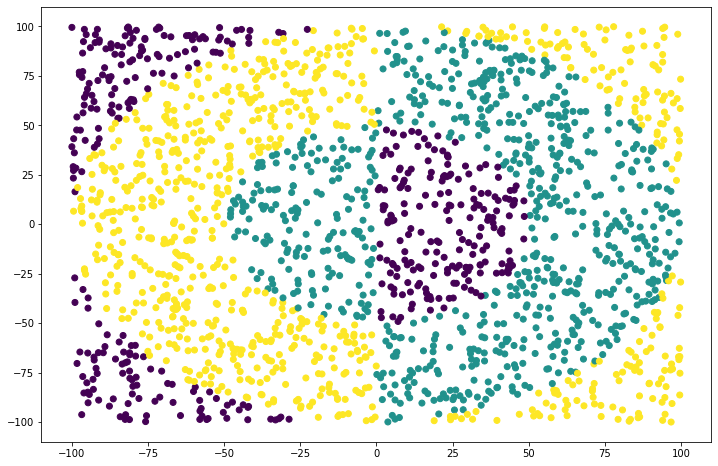

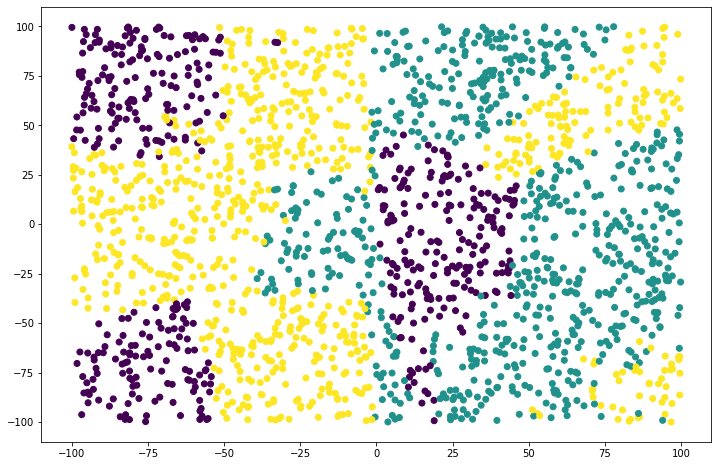

In [154]:
mlp = MLP()

mlp.Input(shape = (None, 2))
mlp.add(100, sigmoid)
mlp.add(3, softmax)
mlp.complie(loss = Cross_entropy, metric=f_score, optimizer=Momentum(0.9))
mlp.fit(X_train.transpose(), y_train_one, eta = 0.001, batch_size= 64, epochs=20000)

y_hat_train = mlp.predict(X_train.transpose())
y_hat_test = mlp.predict(X_test.transpose())
y_hat_train_class = proba_to_class(y_hat_train)
y_hat_test_class = proba_to_class(y_hat_test)


print(f'Train Cross_entoropy: {Cross_entropy().loss(y_hat_train, y_train)}')
print(f'Test Cross_entopopy: {Cross_entropy().loss(y_hat_test, y_test)}')

print(f'Confusion matrix \n{confusion_matrix(y_hat_test_class, y_test[0])}')
print(f'Test F-score {np.mean(f_score(y_hat_test_class, y_test[0]))}')

plt.figure(figsize=(12, 8))
plt.scatter(rings3_regular_test['x'], rings3_regular_test['y'], c = rings3_regular_test['c'])
plt.show()
plt.figure(figsize=(12, 8))
plt.scatter(rings3_regular_test['x'], rings3_regular_test['y'], c = y_hat_test_class)
plt.show()

Cross_entropy: 0.8219165851214906  ----- f_score: nan
Cross_entropy: 0.3752798775186037  ----- f_score: nan
Cross_entropy: 0.3564667992055561  ----- f_score: 0.3655171924076335
Cross_entropy: 0.3491274359537225  ----- f_score: 0.39032267517244135
Cross_entropy: 0.3458961308073298  ----- f_score: nan
Cross_entropy: 0.3482475128851195  ----- f_score: nan
Cross_entropy: 0.34328763126229717  ----- f_score: 0.4041514448921857
Cross_entropy: 0.34283841208921834  ----- f_score: nan
Cross_entropy: 0.3532256877498852  ----- f_score: 0.23884181199051815
Cross_entropy: 0.3384780645918326  ----- f_score: 0.42446397881482145
Cross_entropy: 0.32868485987938917  ----- f_score: 0.4453082920280078
Cross_entropy: 0.3230269195638705  ----- f_score: 0.47728835234564854
Cross_entropy: 0.3327532036457061  ----- f_score: nan
Cross_entropy: 0.3236636968785402  ----- f_score: 0.4781033284836714
Cross_entropy: 0.3050303648162113  ----- f_score: 0.5516575414143073
Cross_entropy: 0.3021905771177829  ----- f_score

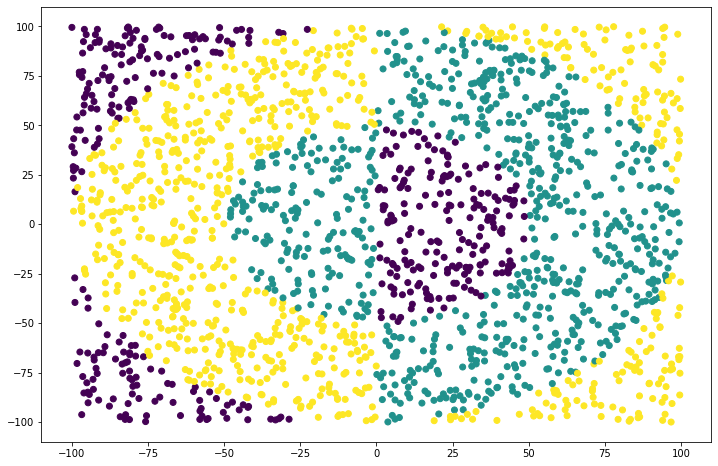

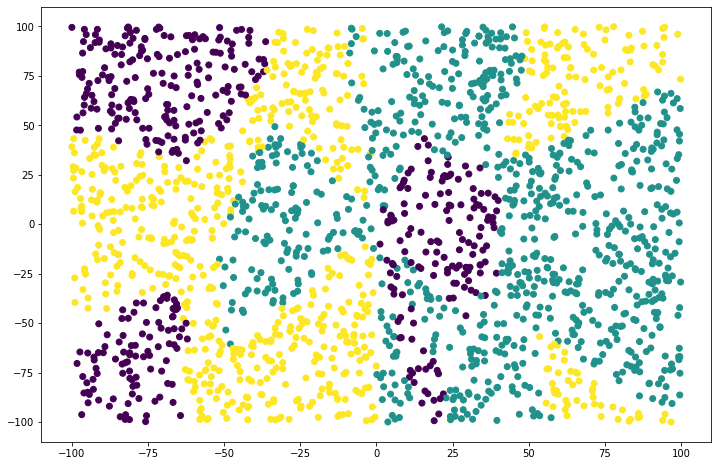

In [193]:
mlp = MLP()

mlp.Input(shape = (None, 2))
mlp.add(30, sigmoid)
mlp.add(60, sigmoid)
mlp.add(3, softmax)
mlp.complie(loss = Cross_entropy, metric=f_score, optimizer=Momentum(0.99))
mlp.fit(X_train.transpose(), y_train_one, eta = 0.002, batch_size= 128, epochs=20000)

y_hat_train = mlp.predict(X_train.transpose())
y_hat_test = mlp.predict(X_test.transpose())
y_hat_train_class = proba_to_class(y_hat_train)
y_hat_test_class = proba_to_class(y_hat_test)


print(f'Train Cross_entoropy: {Cross_entropy().loss(y_hat_train, y_train)}')
print(f'Test Cross_entopopy: {Cross_entropy().loss(y_hat_test, y_test)}')

print(f'Confusion matrix \n{confusion_matrix(y_hat_test_class, y_test[0])}')
print(f'Test F-score {np.mean(f_score(y_hat_test_class, y_test[0]))}')

plt.figure(figsize=(12, 8))
plt.scatter(rings3_regular_test['x'], rings3_regular_test['y'], c = rings3_regular_test['c'])
plt.show()
plt.figure(figsize=(12, 8))
plt.scatter(rings3_regular_test['x'], rings3_regular_test['y'], c = y_hat_test_class)
plt.show()

Cross_entropy: 0.5223384581734677  ----- f_score: 0.3749060032184213
Cross_entropy: 0.3091673967762493  ----- f_score: 0.4956006623504596
Cross_entropy: 0.3017818418055864  ----- f_score: 0.5279962190637573
Cross_entropy: 0.298796020202009  ----- f_score: 0.5209032284552134
Cross_entropy: 0.2951638487695647  ----- f_score: 0.5258354544018666
Cross_entropy: 0.28858918087613744  ----- f_score: 0.5320135689323445
Cross_entropy: 0.28455606471627565  ----- f_score: 0.5427038250453872
Cross_entropy: 0.28317420433382473  ----- f_score: 0.5529800273795006
Cross_entropy: 0.2900866224600904  ----- f_score: 0.5573762415506262
Cross_entropy: 0.2782321252397657  ----- f_score: 0.6053350728000114
Cross_entropy: 0.278894082892374  ----- f_score: 0.5966913553804426
Cross_entropy: 0.2817834315670709  ----- f_score: 0.5845910206163678
Cross_entropy: 0.2789355371999857  ----- f_score: 0.6130846983780357
Cross_entropy: 0.27334574344288515  ----- f_score: 0.6364570411354437
Cross_entropy: 0.278828248200883

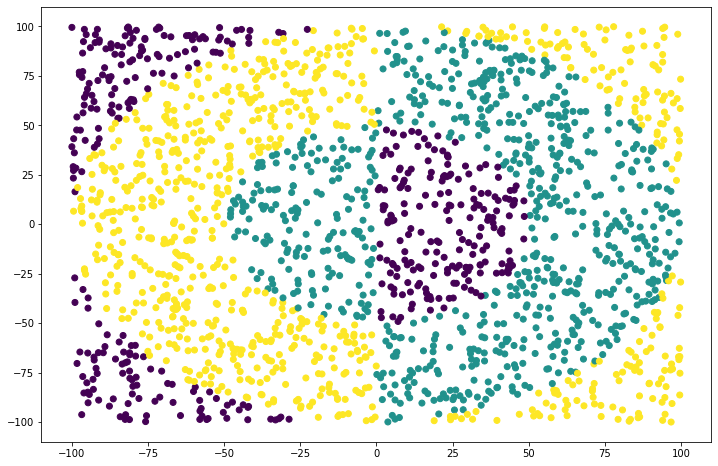

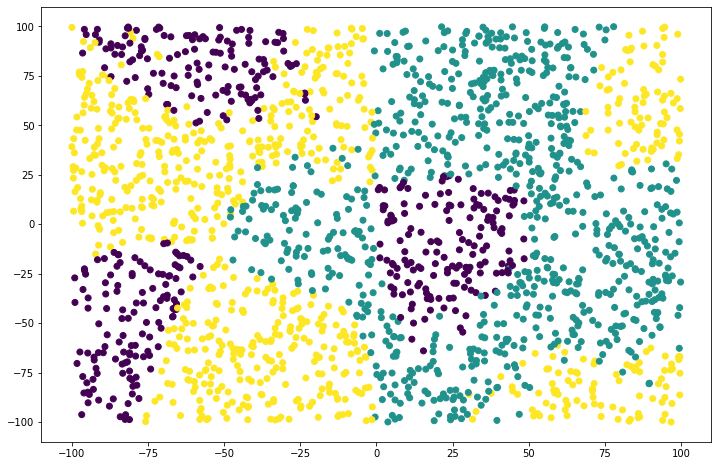

In [212]:
mlp = MLP()

mlp.Input(shape = (None, 2))
mlp.add(100, tanh)
mlp.add(3, softmax)
mlp.complie(loss = Cross_entropy, metric=f_score, optimizer=Momentum(0.9))
mlp.fit(X_train.transpose(), y_train_one, eta = 0.001, batch_size= 128, epochs= 40000)

y_hat_train = mlp.predict(X_train.transpose())
y_hat_test = mlp.predict(X_test.transpose())
y_hat_train_class = proba_to_class(y_hat_train)
y_hat_test_class = proba_to_class(y_hat_test)


print(f'Train Cross_entoropy: {Cross_entropy().loss(y_hat_train, y_train)}')
print(f'Test Cross_entopopy: {Cross_entropy().loss(y_hat_test, y_test)}')

print(f'Confusion matrix \n{confusion_matrix(y_hat_test_class, y_test[0])}')
print(f'Test F-score {np.mean(f_score(y_hat_test_class, y_test[0]))}')

plt.figure(figsize=(12, 8))
plt.scatter(rings3_regular_test['x'], rings3_regular_test['y'], c = rings3_regular_test['c'])
plt.show()
plt.figure(figsize=(12, 8))
plt.scatter(rings3_regular_test['x'], rings3_regular_test['y'], c = y_hat_test_class)
plt.show()

Cross_entropy: 0.5567424580567103  ----- f_score: 0.2734076087718679
Cross_entropy: 0.3076261906312289  ----- f_score: 0.552879644374222
Cross_entropy: 0.2944697751796314  ----- f_score: 0.5908630279636732
Cross_entropy: 0.2788975271122806  ----- f_score: 0.6502421320890432
Cross_entropy: 0.272408489057652  ----- f_score: 0.6355217123222964
Cross_entropy: 0.26395384350920703  ----- f_score: 0.6800476173395419
Cross_entropy: 0.25676306327518134  ----- f_score: 0.6965934722951902
Cross_entropy: 0.24761681041635134  ----- f_score: 0.703390393048236
Cross_entropy: 0.24298218965593743  ----- f_score: 0.728613018203932
Cross_entropy: 0.2389210963569166  ----- f_score: 0.7173320723276811
Cross_entropy: 0.23055983976565053  ----- f_score: 0.7427048260381595
Cross_entropy: 0.2301178172851267  ----- f_score: 0.714470586953856
Cross_entropy: 0.22330189004877413  ----- f_score: 0.7365291075970758
Cross_entropy: 0.22408023590564163  ----- f_score: 0.7039609113302666
Cross_entropy: 0.216499080562042

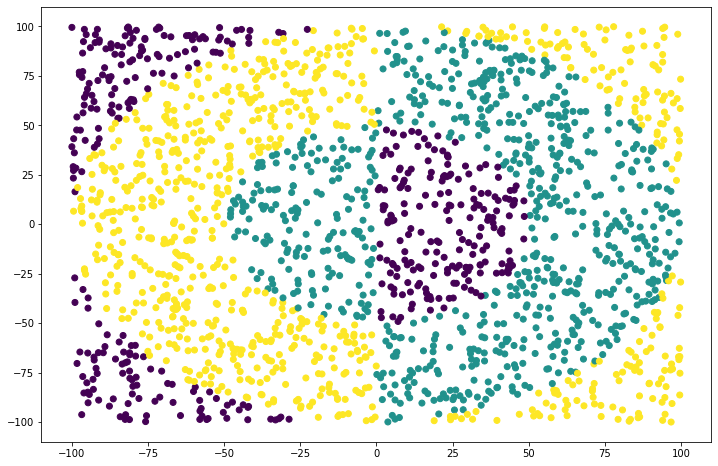

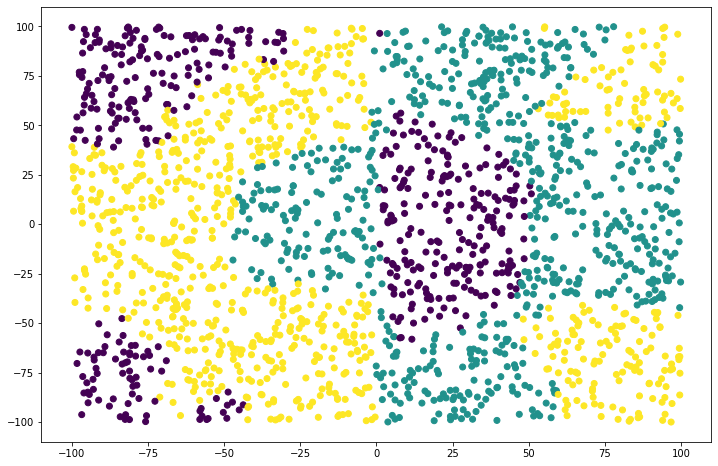

In [272]:
mlp = MLP()

mlp.Input(shape = (None, 2))
mlp.add(100, tanh)
mlp.add(3, softmax)
mlp.complie(loss = Cross_entropy, metric=f_score, optimizer=Momentum(0.9))
mlp.fit(X_train.transpose(), y_train_one, eta = 0.001, batch_size= 128, epochs= 10000)

y_hat_train = mlp.predict(X_train.transpose())
y_hat_test = mlp.predict(X_test.transpose())
y_hat_train_class = proba_to_class(y_hat_train)
y_hat_test_class = proba_to_class(y_hat_test)


print(f'Train Cross_entoropy: {Cross_entropy().loss(y_hat_train, y_train)}')
print(f'Test Cross_entopopy: {Cross_entropy().loss(y_hat_test, y_test)}')

print(f'Confusion matrix \n{confusion_matrix(y_hat_test_class, y_test[0])}')
print(f'Test F-score {np.mean(f_score(y_hat_test_class, y_test[0]))}')

plt.figure(figsize=(12, 8))
plt.scatter(rings3_regular_test['x'], rings3_regular_test['y'], c = rings3_regular_test['c'])
plt.show()
plt.figure(figsize=(12, 8))
plt.scatter(rings3_regular_test['x'], rings3_regular_test['y'], c = y_hat_test_class)
plt.show()

Cross_entropy: 1.374487302595593  ----- f_score: 0.351215551910736
Cross_entropy: 0.3247294382480871  ----- f_score: 0.5108430107567294
Cross_entropy: 0.3184952982797445  ----- f_score: 0.47564696915980975
Cross_entropy: 0.3097849377528134  ----- f_score: 0.4829844662216259
Cross_entropy: 0.32234782347448454  ----- f_score: 0.4317497278320291
Cross_entropy: 0.32589521088070944  ----- f_score: 0.4782789518931719
Cross_entropy: 0.3172565487110539  ----- f_score: 0.456083763533312
Cross_entropy: 0.29172645307985107  ----- f_score: 0.5442989570416651
Cross_entropy: 0.3048995333442648  ----- f_score: 0.47542931659461446
Cross_entropy: 0.2959447403055915  ----- f_score: 0.525596517026359
Cross_entropy: 0.27030958491847906  ----- f_score: 0.6168904423272293
Cross_entropy: 0.26468560295837973  ----- f_score: 0.6420535461317503
Cross_entropy: 0.26515044820351646  ----- f_score: 0.6268917774846628
Cross_entropy: 0.27286517809153055  ----- f_score: 0.5298650745609335
Cross_entropy: 0.254734649815

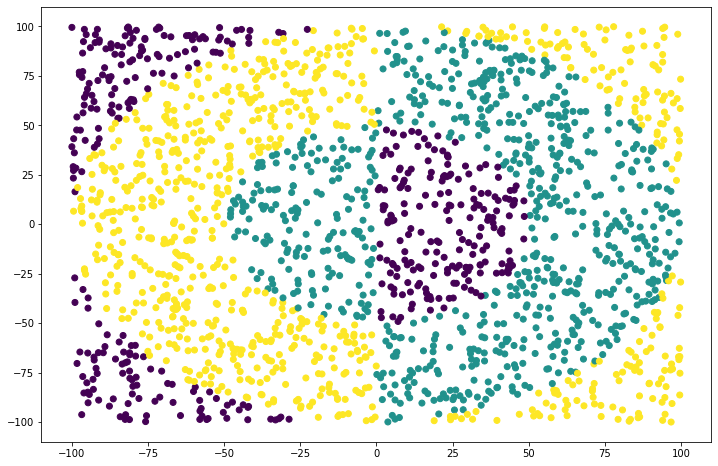

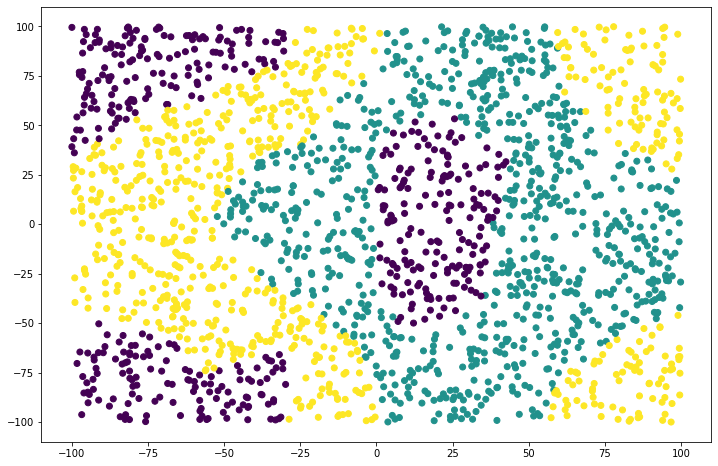

In [271]:
mlp = MLP()

mlp.Input(shape = (None, 2))
mlp.add(100, relu)
mlp.add(3, softmax)
mlp.complie(loss = Cross_entropy, metric=f_score, optimizer=Momentum(0.9))
mlp.fit(X_train.transpose(), y_train_one, eta = 0.001, batch_size= 128, epochs= 10000)

y_hat_train = mlp.predict(X_train.transpose())
y_hat_test = mlp.predict(X_test.transpose())
y_hat_train_class = proba_to_class(y_hat_train)
y_hat_test_class = proba_to_class(y_hat_test)


print(f'Train Cross_entoropy: {Cross_entropy().loss(y_hat_train, y_train)}')
print(f'Test Cross_entopopy: {Cross_entropy().loss(y_hat_test, y_test)}')

print(f'Confusion matrix \n{confusion_matrix(y_hat_test_class, y_test[0])}')
print(f'Test F-score {np.mean(f_score(y_hat_test_class, y_test[0]))}')

plt.figure(figsize=(12, 8))
plt.scatter(rings3_regular_test['x'], rings3_regular_test['y'], c = rings3_regular_test['c'])
plt.show()
plt.figure(figsize=(12, 8))
plt.scatter(rings3_regular_test['x'], rings3_regular_test['y'], c = y_hat_test_class)
plt.show()

In [461]:
data_train = rings5_regular_train
data_test = rings5_regular_test

X_train = np.array(data_train[['x', 'y']])
y_train = np.array(data_train['c'])
y_train = y_train.astype('int32')
y_train_one = one_hot_encoding(y_train)

X_test = np.array(data_test[['x', 'y']])
y_test = np.array([data_test['c']])
y_test = y_test.astype('int32')
y_test_one = one_hot_encoding(y_test)

Cross_entropy: 0.3604972618951966  ----- f_score: 0.25484528552140046
Cross_entropy: 0.19169849255743712  ----- f_score: 0.6049292283907428
Cross_entropy: 0.16769280795046754  ----- f_score: 0.6841377076411236
Cross_entropy: 0.15519831570323775  ----- f_score: 0.6963266901540174
Cross_entropy: 0.14294868840399627  ----- f_score: 0.7519956167659558
Cross_entropy: 0.13579352947859685  ----- f_score: 0.7642312038484633
Cross_entropy: 0.1253969247636983  ----- f_score: 0.7770660376365968
Cross_entropy: 0.1189253177420098  ----- f_score: 0.8138466800197474
Cross_entropy: 0.11372640313908114  ----- f_score: 0.7955880094373194
Cross_entropy: 0.11641366667665676  ----- f_score: 0.8019220254316943
Train Cross_entoropy: [10.70073263  7.85883906  6.97219611  4.39079836  6.48265768]
Test Cross_entopopy: [12.93078929  7.6180097   5.96100131  4.39259126  8.74513149]
Confusion matrix 
[[102.  17.   0.   0.  36.]
 [  4. 277. 160.   2.   0.]
 [  0.  15. 361. 176.   5.]
 [  0.   0. 119. 389.  31.]
 [  2

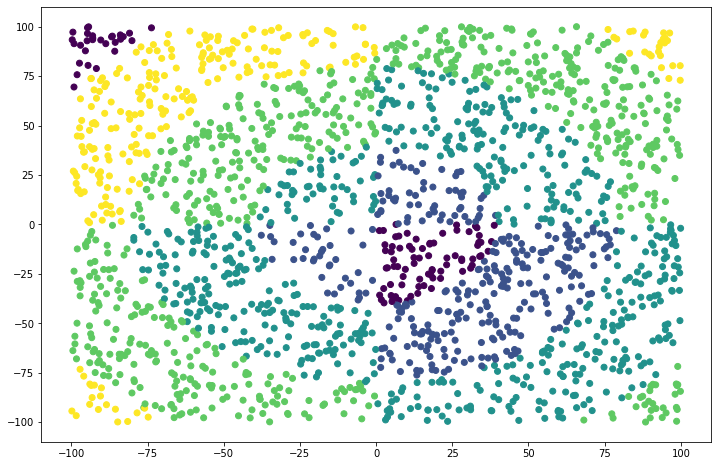

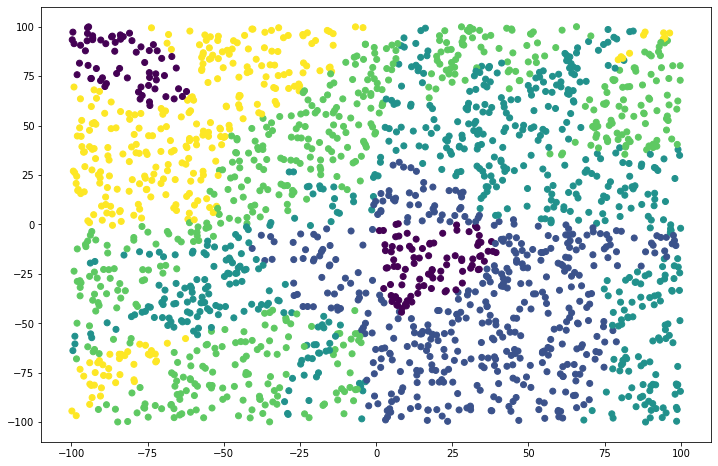

In [464]:
mlp = MLP()

mlp.Input(shape = (None, 2))
mlp.add(100, tanh)
mlp.add(5, softmax)
mlp.complie(loss = Cross_entropy, metric=f_score, optimizer=Momentum(0.9))
mlp.fit(X_train.transpose(), y_train_one, eta = 0.001, batch_size= 128, epochs= 10000)

y_hat_train = mlp.predict(X_train.transpose())
y_hat_test = mlp.predict(X_test.transpose())
y_hat_train_class = proba_to_class(y_hat_train)
y_hat_test_class = proba_to_class(y_hat_test)

print(f'Train Cross_entoropy: {Cross_entropy().loss(y_hat_train, y_train)}')
print(f'Test Cross_entopopy: {Cross_entropy().loss(y_hat_test, y_test)}')

print(f'Confusion matrix \n{confusion_matrix(y_hat_test_class, y_test[0])}')
print(f'Test F-score {np.mean(f_score(y_hat_test_class, y_test[0], to_class=False))}')

plt.figure(figsize=(12, 8))
plt.scatter(rings5_regular_test['x'], rings5_regular_test['y'], c = rings5_regular_test['c'])
plt.show()
plt.figure(figsize=(12, 8))
plt.scatter(rings5_regular_test['x'], rings5_regular_test['y'], c = y_hat_test_class)
plt.show()

Train Cross_entoropy: [10.28076125  7.49375375  6.64425361  3.99440097  6.13757401]
Test Cross_entopopy: [12.68095261  7.46910089  5.72900374  4.05905222  8.16935907]
Confusion matrix 
[[100.  14.   0.   0.  38.]
 [  7. 265.  73.   0.   0.]
 [  0.  30. 442. 155.   5.]
 [  0.   0. 124. 403.  23.]
 [  1.   0.   1. 134. 185.]]
Test F-score 0.7140806648374138


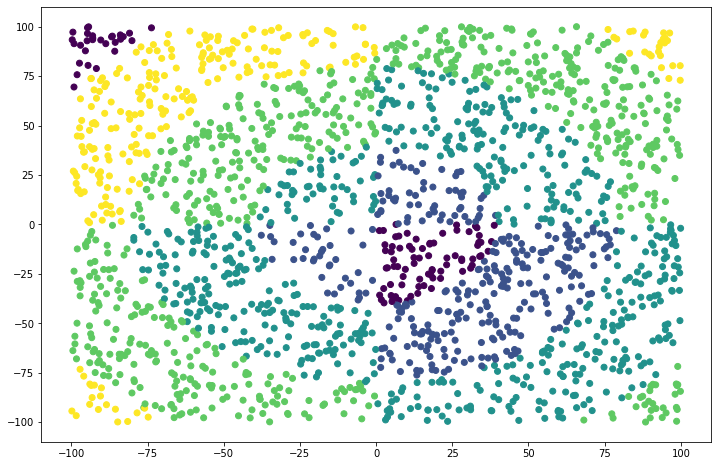

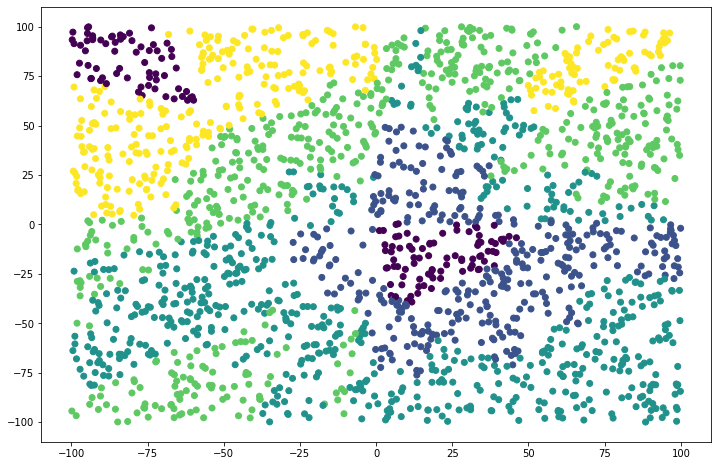

In [463]:
print(f'Train Cross_entoropy: {Cross_entropy().loss(y_hat_train, y_train)}')
print(f'Test Cross_entopopy: {Cross_entropy().loss(y_hat_test, y_test)}')

print(f'Confusion matrix \n{confusion_matrix(y_hat_test_class, y_test[0])}')
print(f'Test F-score {np.mean(f_score(y_hat_test_class, y_test[0], to_class=False))}')

plt.figure(figsize=(12, 8))
plt.scatter(rings5_regular_test['x'], rings5_regular_test['y'], c = rings5_regular_test['c'])
plt.show()
plt.figure(figsize=(12, 8))
plt.scatter(rings5_regular_test['x'], rings5_regular_test['y'], c = y_hat_test_class)
plt.show()

# REGRESSION

In [457]:
data_train = multimodal_large_training
data_test = multimodal_large_test

X_train = np.array([data_train['x']])
y_train = np.array(data_train['y'])

X_test = np.array([data_test['x']])
y_test = np.array([data_test['y']])

def compare(*layers):

    plt.figure(figsize=(15, 12))
    plt.subplots_adjust(hspace=0.5)
    plt.suptitle("Regression", fontsize=18, c = 'w')

    activation = [linear, sigmoid, relu, tanh]
    etas = [0.001, 0.001, 0.0001, 0.001]
    i = 0
    for act, eta in zip(activation, etas):
        start_time = time.time()
        print(act.__name__.upper())
        mlp = MLP()
        mlp.Input(shape = (None, 1))
        for layer in layers:
            mlp.add(layer, act)
        mlp.add(1, linear)
        mlp.complie(loss = MSE, optimizer=Momentum(0.9), metric = mse)
        mlp.fit(X_train, y_train, eta = eta, batch_size = 128, epochs=100)

        y_hat_train = mlp.predict(X_train)
        y_hat_test = mlp.predict(X_test)
        print(f'Train MSE: {mse(y_hat_train, y_train)}')
        print(f'Test MSE: {mse(y_hat_test, y_test)}')
        print(f'Time: {time.time() - start_time}')
        print()
        ax = plt.subplot(2, 2, i + 1) 
        i += 1
        plt.scatter(X_test, y_hat_test, label="y_hat_test")
        plt.scatter(X_test, y_test, label="y_true")
        ax.set_title(act.__name__, color = 'w')
        ax.set_xlabel("")

LINEAR
MSE: 4639.612168638648  ----- mse: 4639.612168638648
MSE: 4566.379071557077  ----- mse: 4566.379071557077
MSE: 4603.604155350723  ----- mse: 4603.604155350723
MSE: 4416.20768368584  ----- mse: 4416.20768368584
MSE: 4534.115962446854  ----- mse: 4534.115962446854
MSE: 4810.78705845631  ----- mse: 4810.78705845631
MSE: 4410.066792639105  ----- mse: 4410.066792639105
MSE: 4456.838392651464  ----- mse: 4456.838392651464
MSE: 4410.316296498398  ----- mse: 4410.316296498398
MSE: 4472.905123989983  ----- mse: 4472.905123989983
Train MSE: 4438.971148968319
Test MSE: 4475.924368649968
Time: 2.916201114654541

SIGMOID
MSE: 4015.469923719298  ----- mse: 4015.469923719298
MSE: 1558.6620709219062  ----- mse: 1558.6620709219062
MSE: 807.8776967677218  ----- mse: 807.8776967677218
MSE: 440.95056365999204  ----- mse: 440.95056365999204
MSE: 320.05696745711595  ----- mse: 320.05696745711595
MSE: 266.7233388131896  ----- mse: 266.7233388131896
MSE: 213.51594067525468  ----- mse: 213.5159406752546

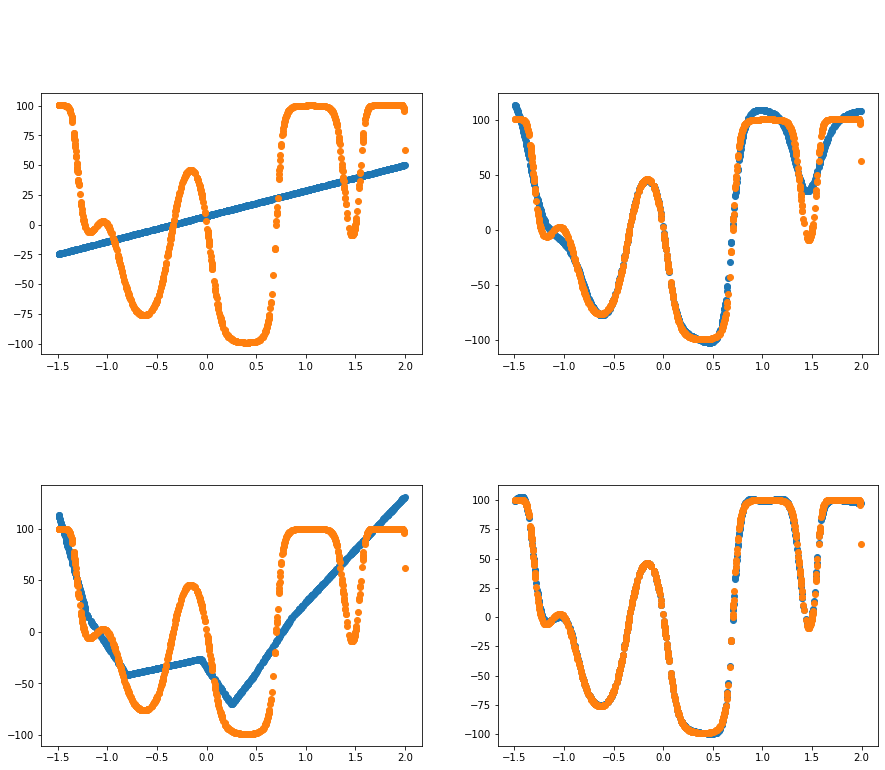

In [458]:
compare(*[100])

LINEAR
MSE: 5182.801088566136  ----- mse: 5182.801088566136
MSE: 5546.295469540742  ----- mse: 5546.295469540742
MSE: 4637.955205057844  ----- mse: 4637.955205057844
MSE: 4643.128106046408  ----- mse: 4643.128106046408
MSE: 4578.658079403476  ----- mse: 4578.658079403476
MSE: nan  ----- mse: nan
MSE: nan  ----- mse: nan
MSE: nan  ----- mse: nan
MSE: nan  ----- mse: nan
MSE: nan  ----- mse: nan
Train MSE: nan
Test MSE: nan
Time: 3.8187875747680664

SIGMOID
MSE: 3262.2084097763795  ----- mse: 3262.2084097763795
MSE: 1487.6258306850775  ----- mse: 1487.6258306850775
MSE: 1367.896751348449  ----- mse: 1367.896751348449
MSE: 1316.0242984560323  ----- mse: 1316.0242984560323
MSE: 1158.4306092563454  ----- mse: 1158.4306092563454
MSE: 1039.9248231884033  ----- mse: 1039.9248231884033
MSE: 1009.0390964827686  ----- mse: 1009.0390964827686
MSE: 1009.5862675207392  ----- mse: 1009.5862675207392
MSE: 1005.4717765020566  ----- mse: 1005.4717765020566
MSE: 1006.1958597248582  ----- mse: 1006.195859

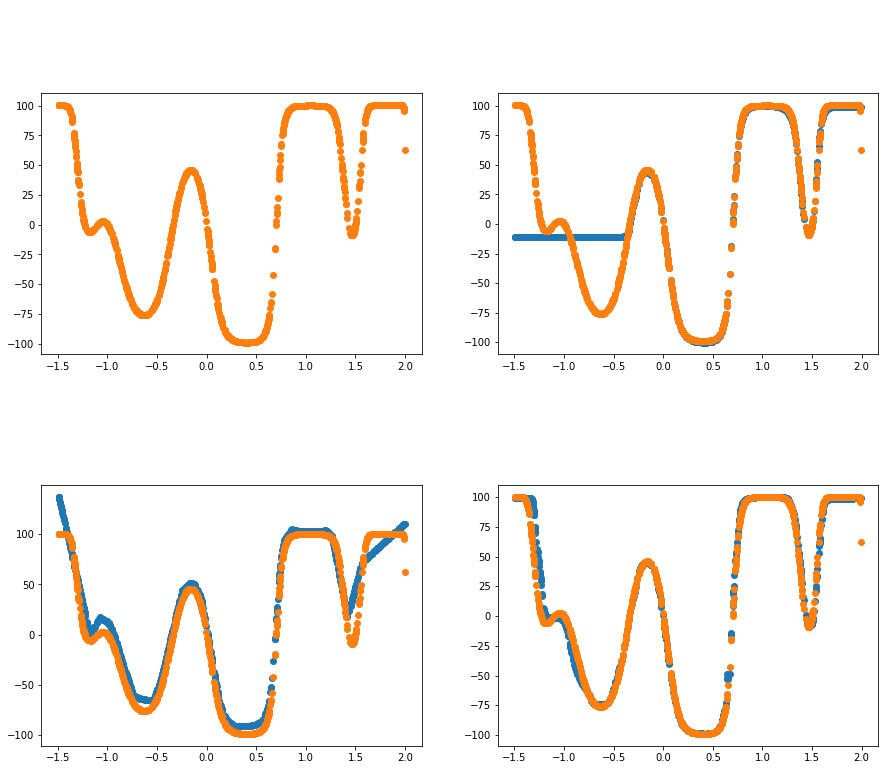

In [459]:
compare(*[30, 100])

LINEAR
MSE: 4508.392069868997  ----- mse: 4508.392069868997
MSE: nan  ----- mse: nan
MSE: nan  ----- mse: nan
MSE: nan  ----- mse: nan
MSE: nan  ----- mse: nan
MSE: nan  ----- mse: nan
MSE: nan  ----- mse: nan
MSE: nan  ----- mse: nan
MSE: nan  ----- mse: nan
MSE: nan  ----- mse: nan
Train MSE: nan
Test MSE: nan
Time: 6.300125598907471

SIGMOID
MSE: 5147.904897742823  ----- mse: 5147.904897742823
MSE: 1508.0163201065934  ----- mse: 1508.0163201065934
MSE: 1446.9508991832129  ----- mse: 1446.9508991832129
MSE: 1266.480759599429  ----- mse: 1266.480759599429
MSE: 1084.0022991717287  ----- mse: 1084.0022991717287
MSE: 1181.6535372093576  ----- mse: 1181.6535372093576
MSE: 625.1272688202556  ----- mse: 625.1272688202556
MSE: 83.12637057715557  ----- mse: 83.12637057715557
MSE: 405.66261949788003  ----- mse: 405.66261949788003
MSE: 281.4982786151083  ----- mse: 281.4982786151083
Train MSE: 149.35544055221953
Test MSE: 152.45531631720056
Time: 21.91240096092224

RELU
MSE: 3350.9755330476023 

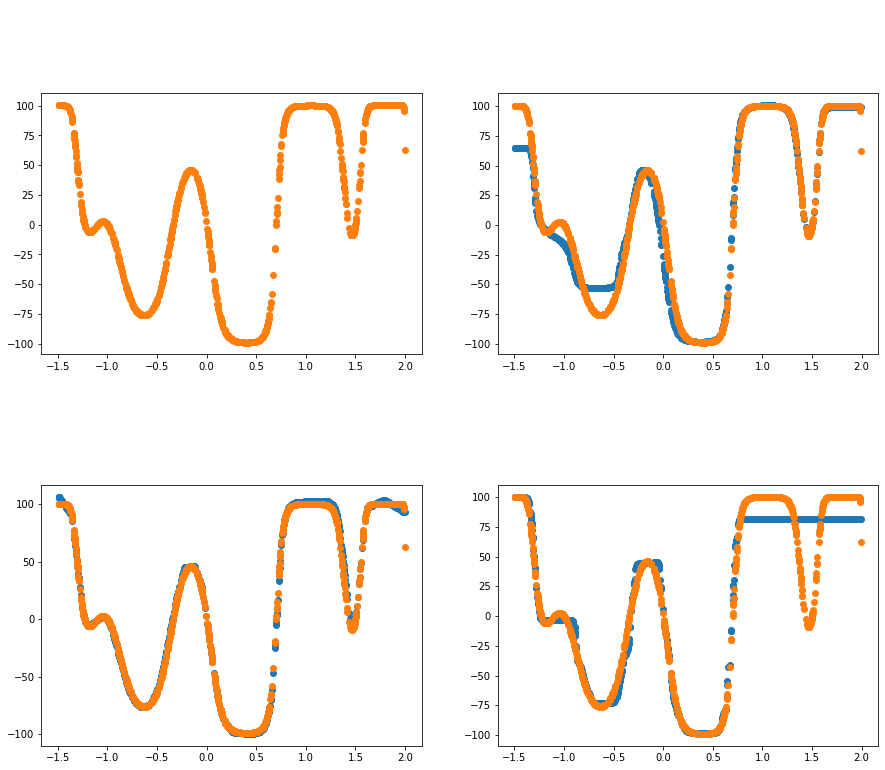

In [460]:
compare(*[30, 100, 100])